In [1]:
import h5py
# %matplotlib inline
%matplotlib notebook
import numpy as np
import sys
import time
import glob
from joblib import Parallel, delayed
import gc

sys.path.append('/home/ripper/kyle/pyVisOS/')

import osh5io
import osh5def
import osh5vis
import osh5utils
import osh5visipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.stats as st
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.signal import hilbert

clrs=plt.rcParams['axes.prop_cycle'].by_key()['color'];
mpl.rcParams['font.serif'] = 'Latin Modern Roman'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

Importing osh5visipy. Please use `%matplotlib notebook' in your jupyter/ipython notebook


In [43]:
def my_plot(data, os_data, window=20, title='', ax=None, clbl='', rlim=None, hilb=False, **kwargs):
    extent = [ os_data.axes[1].ax.min(), os_data.axes[1].ax.max(),
               -os_data.axes[0].ax.max(), os_data.axes[0].ax.max() ]
    xlbl = osh5vis.axis_format(os_data.axes[1].attrs['LONG_NAME'], os_data.axes[1].attrs['UNITS'])
    ylbl = osh5vis.axis_format(os_data.axes[0].attrs['LONG_NAME'], os_data.axes[0].attrs['UNITS'])
    if ax==None:
        plt.imshow(data, extent=extent, aspect='auto', **kwargs)
        plt.xlabel(xlbl)
        plt.ylabel(ylbl)
        if rlim!=None:
            plt.ylim(-rlim,rlim)
        cb = plt.colorbar(pad=0.09)
        cb.set_label(clbl)
        plt.title(title)
        plt.autoscale(False)
        plt.twinx()
        if hilb:
            vals = np.abs(hilbert(data[data.shape[0]/2,:]))
            plt.plot(np.linspace(extent[0],extent[1],vals.size),vals,alpha=0.5,color='r')
            plt.ylabel('Hilbert envelope')
        else:
            weights = np.repeat(1.0, window)/window
            vals = np.convolve(data[data.shape[0]/2,:], weights, 'valid')
            plt.plot(np.linspace(extent[0]+dz*window/2,extent[1]-dz*window/2,vals.size),vals,alpha=0.5,color='r')
            plt.ylabel('Moving average')
        plt.ylim(top=vals.max()+1.4*(vals.max()-vals.min()))
    else:
        ax.imshow(data, extent=extent, aspect='auto', **kwargs)
        ax.set_xlabel(xlbl)
        ax.set_ylabel(ylbl)
        if rlim!=None:
            ax.ylim(-rlim,rlim)
        cb = ax.colorbar(pad=0.09)
        cb.set_label(clbl)
        ax.set_title(title)
        ax.autoscale(False)
        ax1=ax.twinx()
        if hilb:
            vals = np.abs(hilbert(data[data.shape[0]/2,:]))
            ax1.plot(np.linspace(extent[0],extent[1],vals.size),vals,alpha=0.5,color='r')
            ax1.set_ylabel('Hilbert envelope')
        else:
            weights = np.repeat(1.0, window)/window
            vals = np.convolve(data[data.shape[0]/2,:], weights, 'valid')
            ax1.plot(np.linspace(extent[0]+dz*window/2,extent[1]-dz*window/2,vals.size),vals,alpha=0.5,color='r')
            ax1.set_ylabel('Moving average')
        plt.ylim(top=vals.max()+1.4*(vals.max()-vals.min()))
        
# Use fancy scipy interpolation function – very slow
def interp_fields( x, interp, fld='e', calc=True ):
    if fld=='e':
        idx=0
    else: # fld=='b'
        idx=3
    
    flds = np.zeros((x.shape[0],3))
    if calc:
        for f in np.arange(3): # Go over field components
            # Add contributions from the 3 modes
            inds = x[:,3] <= rmax
            flds[inds,f] = interp[f+idx][0]( x[inds,3], x[inds,0], grid=False ) + \
                      ( interp[f+idx][1]( x[inds,3], x[inds,0], grid=False ) * x[inds,1] + \
                        interp[f+idx][2]( x[inds,3], x[inds,0], grid=False ) * x[inds,2] ) / x[inds,3]
    
    return flds

# Just use nearest grid to get the field, much faster
def interp_nearest( x, fields, e, b, n ):
    # TODO: modify i_r and i_z to be more accurate
    e[:] = 0.0
    b[:] = 0.0

    inds = np.logical_and( x[:,3] <= rmax, np.logical_and( x[:,0]<=zmax+n*dt, x[:,0]>=zmin+n*dt ) )
    i_r = ((x[inds,3]-rmin)/dr).round().astype(int)
    i_z = ((x[inds,0]-(zmin+n*dt))/dz).round().astype(int)
    x_r = x[inds,1]/x[inds,3]
    y_r = x[inds,2]/x[inds,3]
    x2_r2 = np.square(x_r)
    xy_r2 = x_r * y_r
    y2_r2 = np.square(y_r)
    
    # E first
    idx = 0
    # z component
    e[inds,0] = fields[0+idx,0,i_r,i_z] + \
                fields[0+idx,1,i_r,i_z] * x_r + \
                fields[0+idx,2,i_r,i_z] * y_r
    # x component
    e[inds,1] = fields[1+idx,0,i_r,i_z] * x_r - \
                fields[2+idx,0,i_r,i_z] * y_r + \
                fields[1+idx,1,i_r,i_z] * x2_r2 - \
                fields[2+idx,1,i_r,i_z] * xy_r2 + \
                fields[1+idx,2,i_r,i_z] * xy_r2 - \
                fields[2+idx,2,i_r,i_z] * y2_r2
    # y component
    e[inds,2] = fields[2+idx,0,i_r,i_z] * x_r + \
                fields[1+idx,0,i_r,i_z] * y_r + \
                fields[2+idx,1,i_r,i_z] * x2_r2 + \
                fields[1+idx,1,i_r,i_z] * xy_r2 + \
                fields[2+idx,2,i_r,i_z] * xy_r2 + \
                fields[1+idx,2,i_r,i_z] * y2_r2
                
    # B next
    idx = 3
    # z component
    b[inds,0] = fields[0+idx,0,i_r,i_z] + \
                fields[0+idx,1,i_r,i_z] * x_r + \
                fields[0+idx,2,i_r,i_z] * y_r
    # x component
    b[inds,1] = fields[1+idx,0,i_r,i_z] * x_r - \
                fields[2+idx,0,i_r,i_z] * y_r + \
                fields[1+idx,1,i_r,i_z] * x2_r2 - \
                fields[2+idx,1,i_r,i_z] * xy_r2 + \
                fields[1+idx,2,i_r,i_z] * xy_r2 - \
                fields[2+idx,2,i_r,i_z] * y2_r2
    # y component
    b[inds,2] = fields[2+idx,0,i_r,i_z] * x_r + \
                fields[1+idx,0,i_r,i_z] * y_r + \
                fields[2+idx,1,i_r,i_z] * x2_r2 + \
                fields[1+idx,1,i_r,i_z] * xy_r2 + \
                fields[2+idx,2,i_r,i_z] * xy_r2 + \
                fields[1+idx,2,i_r,i_z] * y2_r2

def dudt_boris( p_in, ep, bp ):

    tem = 0.5 * dt / rqm

    ep = ep * tem
    utemp = p_in + ep

    gam_tem = tem / np.sqrt( 1.0 + np.sum( np.square(utemp), axis=1 ) )

    bp = bp * np.tile(np.expand_dims(gam_tem,1),3)

    p_in[:,:] = utemp + np.cross(utemp,bp,axis=1)

    bp = bp * np.tile(np.expand_dims( 2.0 / ( 1.0 + np.sum( np.square(bp), axis=1 ) ), 1), 3)

    utemp = utemp + np.cross(p_in,bp,axis=1)

    p_in[:,:] = utemp + ep

def dudt_boris_e( p_in, ep ):

    tem = dt / rqm

    p_in = p_in + ep * tem
    
    return p_in

def dudt_boris_b( p_in, bp ):

    tem = 0.5 * dt / rqm

    utemp = p_in

    gam_tem = tem / np.sqrt( 1.0 + np.sum( np.square(utemp), axis=1 ) )

    bp = bp * np.tile(np.expand_dims(gam_tem,1),3)

    p_in = utemp + np.cross(utemp,bp,axis=1)

    bp = bp * np.tile(np.expand_dims( 2.0 / ( 1.0 + np.sum( np.square(bp), axis=1 ) ), 1), 3)

    p_in = utemp + np.cross(p_in,bp,axis=1)
    
    return p_in

def sim(x,p,disp=0,perc_mod=5):
    # Run simulation
    n = 0
    print_percent = -1
    e = np.zeros((x.shape[0],3))
    b = np.zeros((x.shape[0],3))
    # print(x.shape[0])

    if disp==0: print("Running with T={}".format(T_init))
    while n <= nmin or np.any(x[:,2]>=-rmax):
        interp_nearest( x, fields, e, b, n )
        dudt_boris( p, e, b )
        rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
        x[:,:3] = x[:,:3] + p * np.tile(np.expand_dims(rgamma*dt,1),3)
        x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) )

        percent = np.round(n/nmin*100).astype(int)
        if percent%perc_mod==0 and percent > print_percent:
            if disp==0: print('{}%'.format(percent))
            print_percent = percent
        n += 1
        
    return x,p

In [7]:
# Grab data for all modes/fields and store it as an interpolation function
fldr = 'q3d-n1e15-bubble-1'
flds = ['e1','e2','e3','b1','b2','b3']
mode_sub = ['0-re','1-re','1-im']

# Get and store r/z arrays to use with all fields
data=osh5io.read_h5(glob.glob(fldr+'/e1*0-re*')[0])
r = np.linspace(data.axes[0].min, data.axes[0].max, data.axes[0].size)
z = np.linspace(data.axes[1].min, data.axes[1].max, data.axes[1].size)
nr = r.size
nz = z.size
dr = r[1] - r[0]
dz = z[1] - z[0]
# r_interp = np.linspace(r.min(),    r.max()+dr, nr+1) # Extend these arrays to have zero outside acceptable values
# z_interp = np.linspace(z.min()-dz, z.max()+dz, nz+2)
rmin = r.min()
rmax = r.max()
zmin = z.min()
zmax = z.max()

# Get interpolation function for each component
# interp = [] # will be interp[fld_type,mode]
fields = np.zeros((len(flds),len(mode_sub),nr,nz))
for i,fld in enumerate(flds):
    # interp.append([]) # Append empty list to get a sort of two-dimensional list
    for j,mode in enumerate(mode_sub):
        data=osh5io.read_h5(glob.glob('{}/{}_cyl_m-{}*'.format(fldr,fld,mode))[0])
        # Use data array with zeros on the edges to fix interpolation outside of accepted values
        # interp_data = np.zeros((r_interp.size,z_interp.size))
        # interp_data[:-1,1:-1] = data.values
        # interp[i].append(RBS(r_interp,z_interp,interp_data,kx=3,ky=3))
        fields[i,j,:,:] = data.values # Or just store it in this array since interpolation is slow

mag_e_half = np.sqrt( np.sum( np.square( np.sum( fields[:3,:2,:,:], axis=1 ) ), axis=0 ) )
size_x = 2*(mag_e_half.shape[0]-1)
mag_e = np.zeros((size_x,mag_e_half.shape[1]))
mag_e[size_x/2:,:] = mag_e_half[1:,:]
mag_e[:size_x/2,:] = np.flip( mag_e_half[1:,:], axis=0 )
mag_b_half = np.sqrt( np.sum( np.square( np.sum( fields[3:,:2,:,:], axis=1 ) ), axis=0 ) )
mag_b = np.zeros((size_x,mag_b_half.shape[1]))
mag_b[size_x/2:,:] = mag_b_half[1:,:]
mag_b[:size_x/2,:] = np.flip( mag_b_half[1:,:], axis=0 )

# Initialize particle arrays
npart_in = 1e3 # Approximate number of particles
npart_str = '{:1.0E}'.format(npart_in).replace('+','')
l_r = 2*r.max()
l_z = z.max() - z.min()
# Number of particles in each direction
npr = int(np.sqrt(npart_in*l_r/l_z))
npr = npr + 1 - npr%2
npz = int(np.sqrt(npart_in*l_z/l_r))
npart = npr*npz # Calculate actual number of particles

T_init = 55 # Initial temperature in MeV

rqm = -1.0 # Mass to charge ratio of electrons
dt = np.min([dz,dr]) # time step
nmin = 2*r.max() / dt # Minimum number of time steps to traverse directly across the box

# Initialize position array
x = np.zeros((npart,4)) # z,x,y,r
zpmin=z.min(); zpmax=z.max() + nmin*dt
rpmin=-r.max(); rpmax=r.max()
z_init = np.linspace(zpmin,zpmax,npz)
r_init = np.linspace(rpmin,rpmax,npr)
x[:,0] = np.tile(z_init,npr) # Initialize as a spread across z
x[:,1] = np.repeat(r_init,npz) # Initialize as a spread across x
x[:,2] = rmax # Initialize all particles at max(r) in y
x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) ) # Calculate r based on initial position

# Initialize momentum array with a small amount of thermal noise in each direction
p_temp = np.sqrt(T_init*1e6/0.511e6)
p = np.random.normal(scale=p_temp*0.0,size=(npart,3))
p[:,2] = p[:,2] - p_temp

# Run simulation
# n = 0
# print_percent = -1
# e = np.zeros((x.shape[0],3))
# b = np.zeros((x.shape[0],3))

# print("Running with T={}".format(T_init))
# while n <= nmin or np.any(x[:,2]>=-rmax):
#     interp_nearest( x, fields, e, b )
#     dudt_boris( p, e, b )
#     rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
#     x[:,:3] = x[:,:3] + p * np.tile(np.expand_dims(rgamma*dt,1),3)
#     x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) )

#     percent = np.round(n/nmin*100).astype(int)
#     if percent%5==0 and percent > print_percent:
#         print('{}%'.format(percent))
#         print_percent = percent
#     n += 1

sim(x,p)

# Save output data to plot later if desired
np.savez('{}/data_{}_T_{}-0-trans'.format(fldr,npart_str,T_init),x=x,p=p)

Running with T=55
0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


In [ ]:
# Grab data for all modes/fields and store it as an interpolation function
fldr = 'q3d-n1e15-bubble-1'
flds = ['e1','e2','e3','b1','b2','b3']
mode_sub = ['0-re','1-re','1-im']

# Get and store r/z arrays to use with all fields
data=osh5io.read_h5(glob.glob(fldr+'/e1*0-re*')[0])
r = np.linspace(data.axes[0].min, data.axes[0].max, data.axes[0].size)
z = np.linspace(data.axes[1].min, data.axes[1].max, data.axes[1].size)
nr = r.size
nz = z.size
dr = r[1] - r[0]
dz = z[1] - z[0]
# r_interp = np.linspace(r.min(),    r.max()+dr, nr+1) # Extend these arrays to have zero outside acceptable values
# z_interp = np.linspace(z.min()-dz, z.max()+dz, nz+2)
rmin = r.min()
rmax = r.max()
zmin = z.min()
zmax = z.max()

# Get interpolation function for each component
# interp = [] # will be interp[fld_type,mode]
fields = np.zeros((len(flds),len(mode_sub),nr,nz))
for i,fld in enumerate(flds):
    # interp.append([]) # Append empty list to get a sort of two-dimensional list
    for j,mode in enumerate(mode_sub):
        data=osh5io.read_h5(glob.glob('{}/{}_cyl_m-{}*'.format(fldr,fld,mode))[0])
        # Use data array with zeros on the edges to fix interpolation outside of accepted values
        # interp_data = np.zeros((r_interp.size,z_interp.size))
        # interp_data[:-1,1:-1] = data.values
        # interp[i].append(RBS(r_interp,z_interp,interp_data,kx=3,ky=3))
        fields[i,j,:,:] = data.values # Or just store it in this array since interpolation is slow

mag_e_half = np.sqrt( np.sum( np.square( np.sum( fields[:3,:2,:,:], axis=1 ) ), axis=0 ) )
size_x = 2*(mag_e_half.shape[0]-1)
mag_e = np.zeros((size_x,mag_e_half.shape[1]))
mag_e[size_x/2:,:] = mag_e_half[1:,:]
mag_e[:size_x/2,:] = np.flip( mag_e_half[1:,:], axis=0 )
mag_b_half = np.sqrt( np.sum( np.square( np.sum( fields[3:,:2,:,:], axis=1 ) ), axis=0 ) )
mag_b = np.zeros((size_x,mag_b_half.shape[1]))
mag_b[size_x/2:,:] = mag_b_half[1:,:]
mag_b[:size_x/2,:] = np.flip( mag_b_half[1:,:], axis=0 )

# Initialize particle arrays
npart_in = 1e7 # Approximate number of particles
delta_p = 0.0
npart_str = '{:1.0E}'.format(npart_in).replace('+','')
dp_str = '{:1.0E}'.format(delta_p).replace('+','')
l_r = 2*r.max()
l_z = z.max() - z.min()
# Number of particles in each direction
npr = int(np.sqrt(npart_in*l_r/l_z))
npr = npr + 1 - npr%2
npz = int(np.sqrt(npart_in*l_z/l_r))
npart = npr*npz # Calculate actual number of particles

T_init = 55 # Initial temperature in MeV

rqm = -1.0 # Mass to charge ratio of electrons
dt = np.min([dz,dr]) # time step
nmin = 2*r.max() / dt # Minimum number of time steps to traverse directly across the box

# Initialize position array
x = np.zeros((npart,4)) # z,x,y,r
zpmin=z.min(); zpmax=z.max() + nmin*dt
rpmin=-r.max(); rpmax=r.max()
z_init = np.linspace(zpmin,zpmax,npz)
r_init = np.linspace(rpmin,rpmax,npr)
x[:,0] = np.tile(z_init,npr) # Initialize as a spread across z
x[:,1] = np.repeat(r_init,npz) # Initialize as a spread across x
x[:,2] = rmax # Initialize all particles at max(r) in y
x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) ) # Calculate r based on initial position

# Initialize momentum array with a small amount of thermal noise in each direction
p_temp = np.sqrt(T_init*1e6/0.511e6)
p = np.random.normal(scale=p_temp*delta_p,size=(npart,3))
p[:,2] = p[:,2] - p_temp

n_threads = 16

idx = (np.arange(n_threads+1)*npart)/n_threads
out=Parallel(n_jobs=n_threads,max_nbytes=None) \
(delayed(sim)(x[idx[i]:idx[i+1],:],p[idx[i]:idx[i+1],:],disp=i-n_threads/2,perc_mod=1) for i in np.arange(n_threads))
for i, (xx,pp) in enumerate(out):
    x[idx[i]:idx[i+1],:]=xx
    p[idx[i]:idx[i+1],:]=pp
print('All done')

# sim(x,p)

# Save output data to plot later if desired
np.savez('{}/data_{}_T_{}_dp_{}'.format(fldr,npart_str,T_init,dp_str),x=x,p=p)

Running with T=55
0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%


<IPython.core.display.Javascript object>


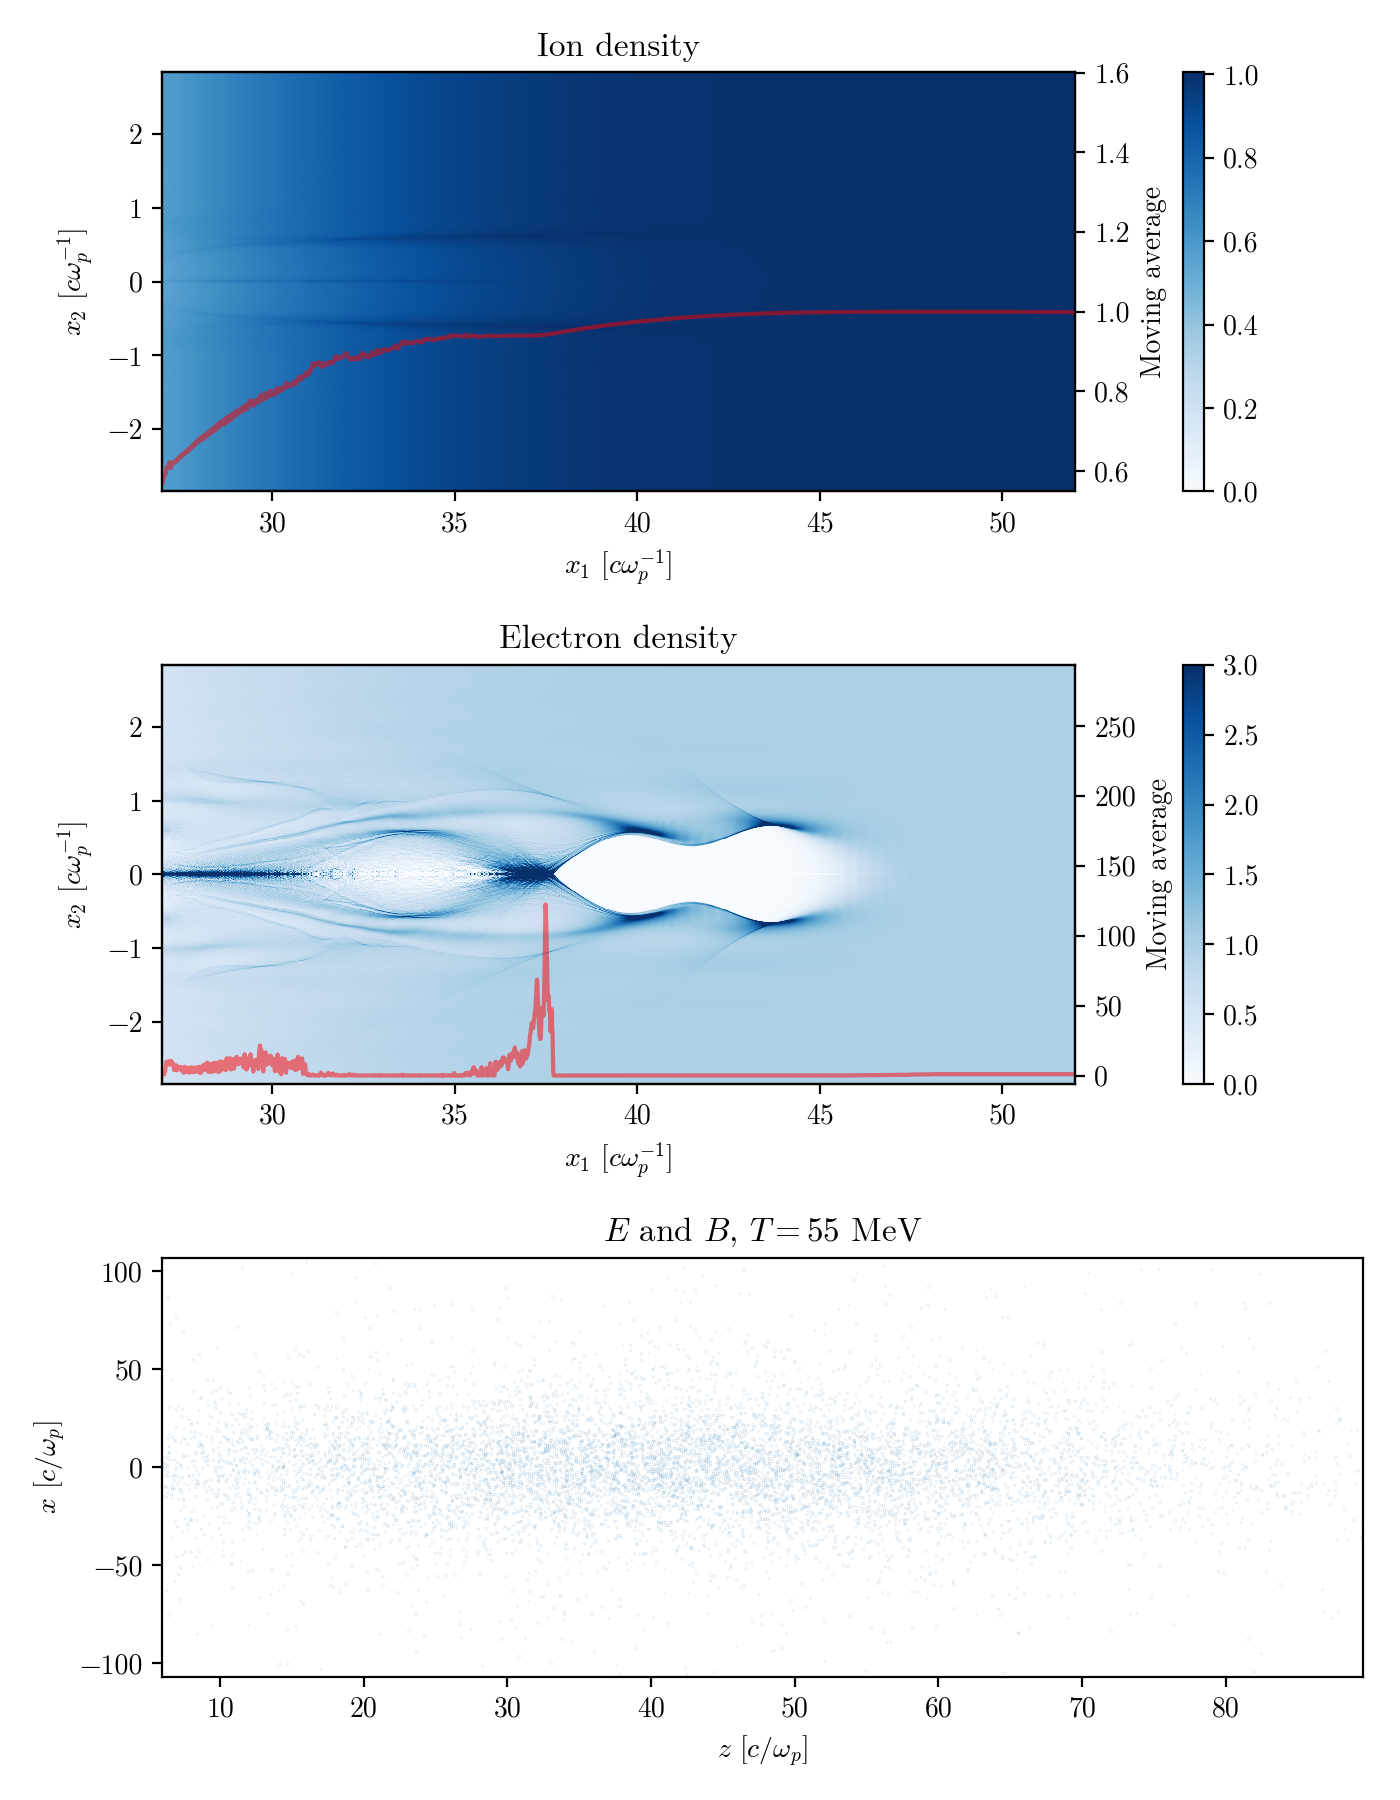

In [12]:
# Plot raw particle positions at screen
fldr = 'q3d-n1e15-bubble-1'
npart_str = '{:1.0E}'.format(1e4).replace('+','')

dat_ele = osh5io.read_h5(glob.glob(fldr+'/charge*electrons*0-re*')[0])
size_x = 2*(dat_ele.shape[0]-1)
charge_e = np.zeros((size_x,dat_ele.shape[1]))
charge_e[size_x/2:,:] = dat_ele.values[1:,:]
charge_e[:size_x/2,:] = np.flip( dat_ele.values[1:,:], axis=0 )
dat_ion = osh5io.read_h5(glob.glob(fldr+'/charge*ions*0-re*')[0])
charge_i = np.zeros_like(charge_e)
charge_i[size_x/2:,:] = dat_ion.values[1:,:]
charge_i[:size_x/2,:] = np.flip( dat_ion.values[1:,:], axis=0 )

# Get and store r/z arrays to use with all fields
r = np.linspace(dat_ele.axes[0].min, dat_ele.axes[0].max, dat_ele.axes[0].size)
z = np.linspace(dat_ele.axes[1].min, dat_ele.axes[1].max, dat_ele.axes[1].size)
nr = r.size
nz = z.size
dr = r[1] - r[0]
dz = z[1] - z[0]
# r_interp = np.linspace(r.min(),    r.max()+dr, nr+1) # Extend these arrays to have zero outside acceptable values
# z_interp = np.linspace(z.min()-dz, z.max()+dz, nz+2)
rmin = r.min()
rmax = r.max()
zmin = z.min()
zmax = z.max()

Temps=[55]
plt.figure(figsize=(7*len(Temps),3*3))
pp=301+10*len(Temps)
for i,T_init in enumerate(Temps):
    plt.subplot(3,len(Temps),1+i)
    my_plot(charge_i,dat_ion,title='Ion density',cmap='Blues',vmin=0)
    plt.subplot(3,len(Temps),1+i+len(Temps))
    my_plot(np.abs(charge_e),dat_ele,title='Electron density',cmap='Blues',vmin=0,vmax=3)
    
    # Load in saved data
    data=np.load('{}/data_{}_T_{}.npz'.format(fldr,npart_str,T_init))
    x=data['x']; p=data['p']
    
    # Calculate positions at the screen
    dist = 20 # distance to screen in cm
    d = -dist * 1e-2 / 11.894e-6 - rmax
    rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
    t = ( d - x[:,2] ) / ( p[:,2] * rgamma )
    xfinal = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t,1),3)
    xfinal[:,0] = xfinal[:,0] - rmax # Set the final z to the z coordinate when it was in the middle of the wake
    
    perc = 0.96
    hist, edges = np.histogram(np.abs(xfinal[:,1]),bins=1500,normed=True)
    w_ind_r = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_r = edges[w_ind_r+1]
    
    hist, edges = np.histogram(xfinal[:,0],bins=1500,normed=True)
    w_ind_u = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_u = edges[w_ind_u+1]
    w_ind_l = np.argmax(np.cumsum(np.flip(hist,axis=0))*(edges[1]-edges[0])>perc)
    wind_l = np.flip(edges,axis=0)[w_ind_l+1]
    
    plt.subplot(3,len(Temps),1+i+2*len(Temps))
    plt.scatter(xfinal[:,0],xfinal[:,1],s=.001)
    plt.xlim(wind_l,wind_u)
    plt.ylim(-wind_r,wind_r)
    plt.xlabel('$z$ [$c/\omega_p$]')
    plt.ylabel('$x$ [$c/\omega_p$]')
    plt.title('$E$ and $B$, $T={}$ MeV'.format(T_init))

plt.tight_layout()
# plt.savefig('radiography_particles.png',dpi=300)
plt.show()

<IPython.core.display.Javascript object>


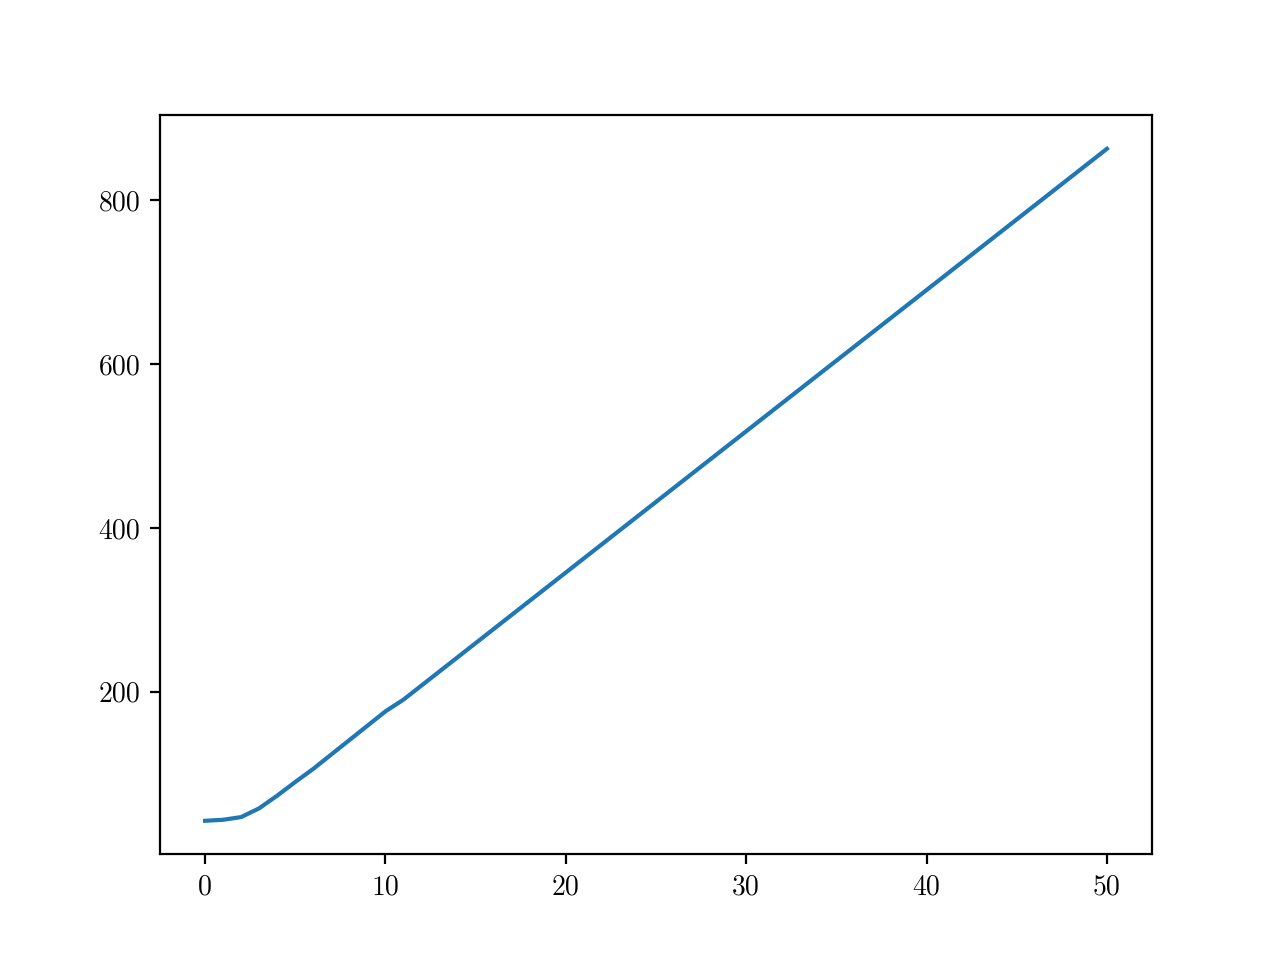

In [86]:
# Print width of screen based on distance from plasma
n_sim = 132
npart_str = '{:1.0E}'.format(1e5).replace('+','')

dat_ele = osh5io.read_h5('MODE-0-RE/charge_cyl_m-electrons0-re-000{:03d}.h5'.format(n_sim))
size_x = 2*(dat_ele.shape[0]-1)
charge_e = np.zeros((size_x,dat_ele.shape[1]))
charge_e[size_x/2:,:] = dat_ele.values[1:,:]
charge_e[:size_x/2,:] = np.flip( dat_ele.values[1:,:], axis=0 )
dat_ion = osh5io.read_h5('MODE-0-RE/charge_cyl_m-ions0-re-000{:03d}.h5'.format(n_sim))
charge_i = np.zeros_like(charge_e)
charge_i[size_x/2:,:] = dat_ion.values[1:,:]
charge_i[:size_x/2,:] = np.flip( dat_ion.values[1:,:], axis=0 )

# Get and store r/z arrays to use with all fields
r = np.linspace(dat_ele.axes[0].min, dat_ele.axes[0].max, dat_ele.axes[0].size)
z = np.linspace(dat_ele.axes[1].min, dat_ele.axes[1].max, dat_ele.axes[1].size)
nr = r.size
nz = z.size
dr = r[1] - r[0]
dz = z[1] - z[0]
# r_interp = np.linspace(r.min(),    r.max()+dr, nr+1) # Extend these arrays to have zero outside acceptable values
# z_interp = np.linspace(z.min()-dz, z.max()+dz, nz+2)
rmin = r.min()
rmax = r.max()
zmin = z.min()
zmax = z.max()

distances = np.arange(51)
lims = np.zeros(distances.size)
for i,dist in enumerate(distances):
    T_init = 55
    
    # Load in saved data
    data=np.load('data_{}_T_{}_n_{}.npz'.format(npart_str,T_init,n_sim))
    x=data['x']; p=data['p']
    
    # Calculate positions at the screen
    # dist = 20 # distance to screen in cm
    d = -dist * 1e-2 / 11.894e-6 - rmax
    rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
    t = ( d - x[:,2] ) / ( p[:,2] * rgamma )
    xfinal = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t,1),3)
    xfinal[:,0] = xfinal[:,0] - rmax # Set the final z to the z coordinate when it was in the middle of the wake
    
    perc=0.95
    hist, edges = np.histogram(np.abs(xfinal[:,1]),bins=1500,normed=True)
    w_ind_r = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    lims[i] = edges[w_ind_r+1]

plt.figure()
plt.plot(lims)
plt.show()

<IPython.core.display.Javascript object>


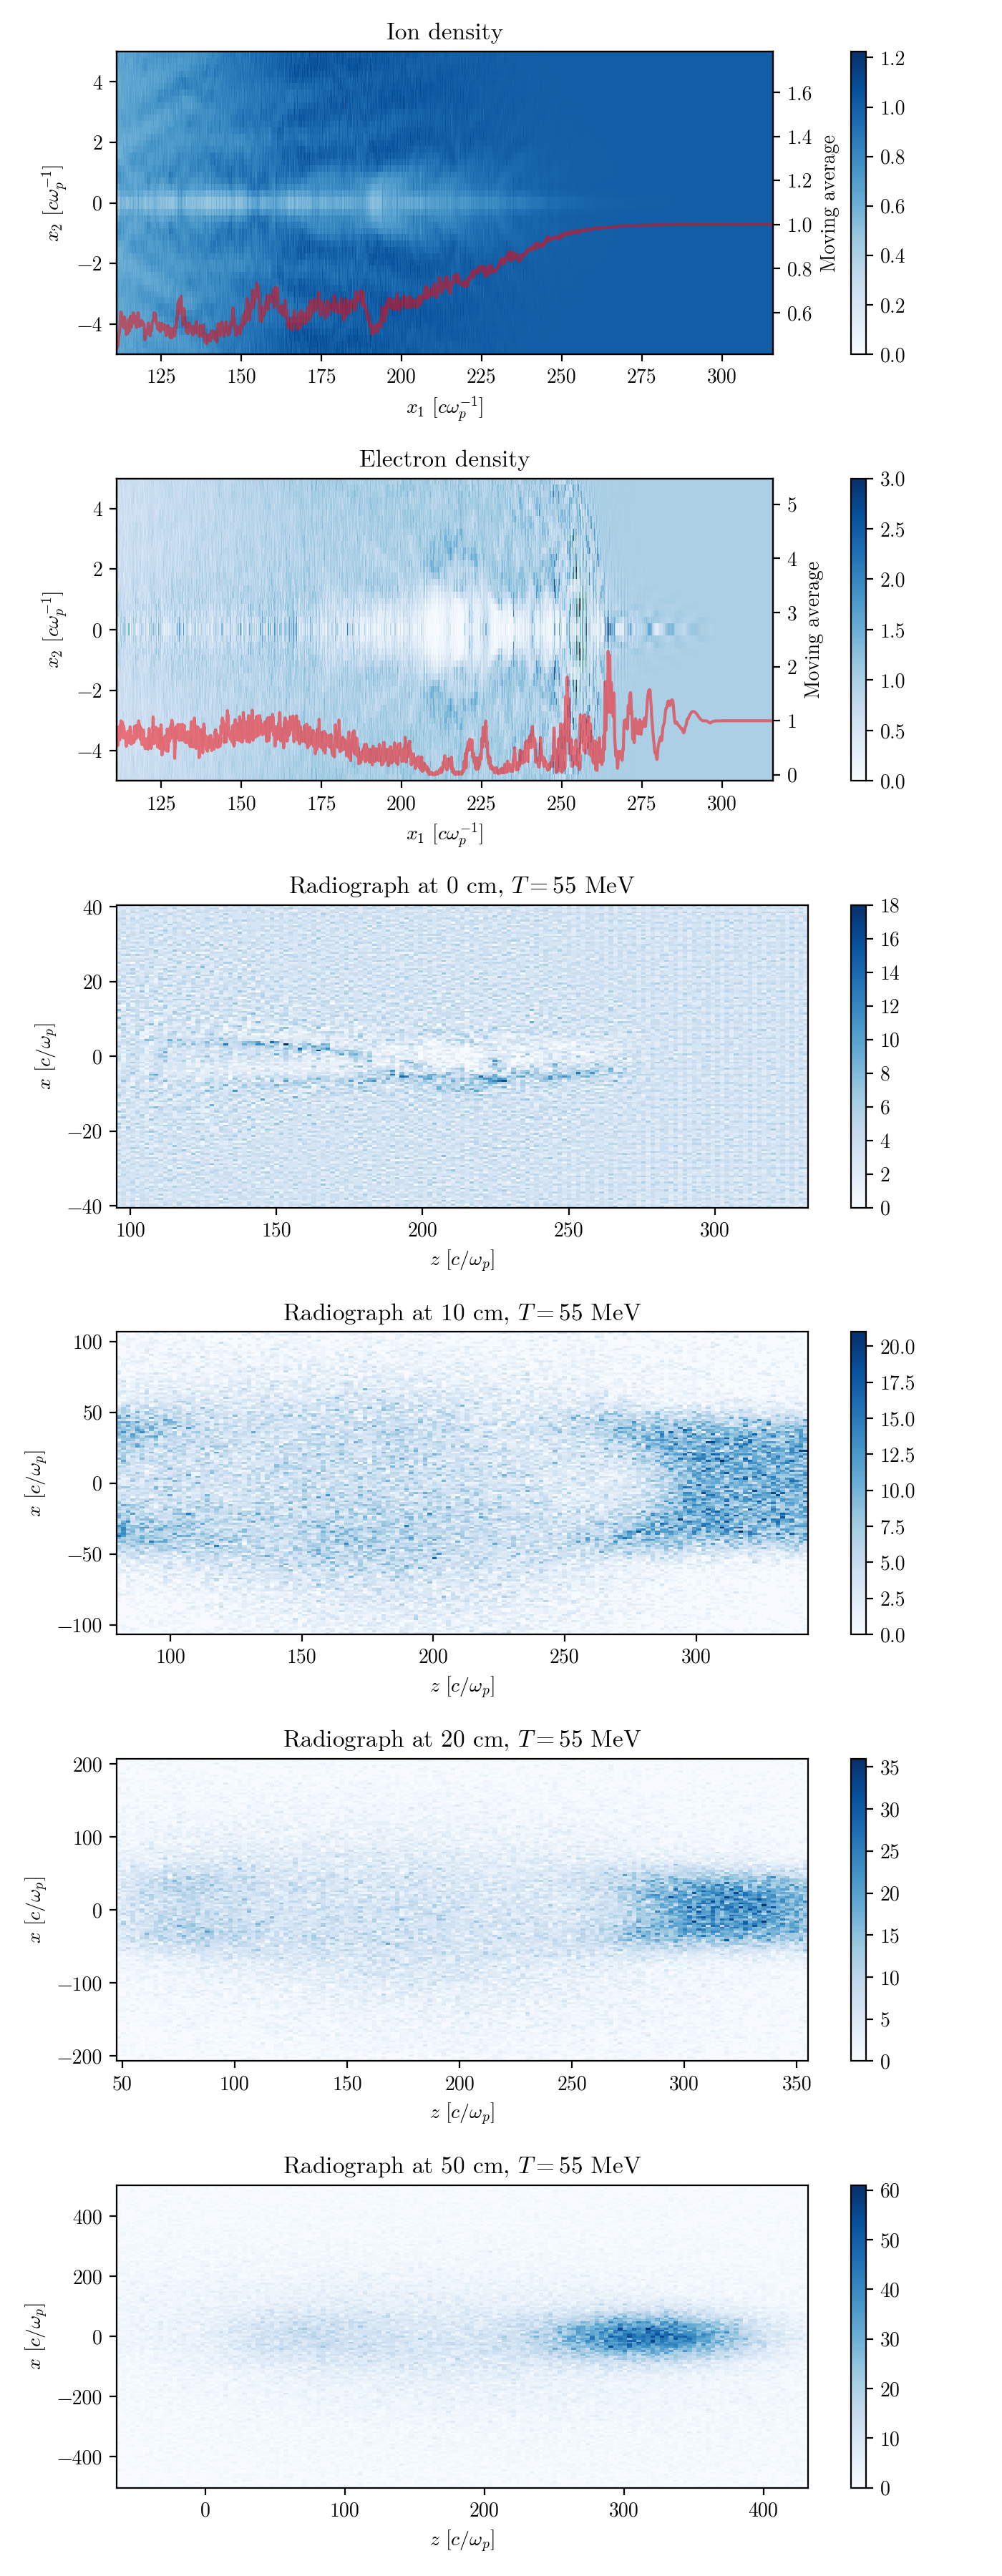

avg=213.502232946, act=213.504305632
avg=210.929025294, act=213.504305632
avg=201.101119779, act=213.504305632
avg=184.007903766, act=213.504305632


In [15]:
# Plot histogram of density at screen
n_sim = 132
npart_str = '{:1.0E}'.format(1e5).replace('+','')

dat_ele = osh5io.read_h5('MODE-0-RE/charge_cyl_m-electrons0-re-000{:03d}.h5'.format(n_sim))
size_x = 2*(dat_ele.shape[0]-1)
charge_e = np.zeros((size_x,dat_ele.shape[1]))
charge_e[size_x/2:,:] = dat_ele.values[1:,:]
charge_e[:size_x/2,:] = np.flip( dat_ele.values[1:,:], axis=0 )
dat_ion = osh5io.read_h5('MODE-0-RE/charge_cyl_m-ions0-re-000{:03d}.h5'.format(n_sim))
charge_i = np.zeros_like(charge_e)
charge_i[size_x/2:,:] = dat_ion.values[1:,:]
charge_i[:size_x/2,:] = np.flip( dat_ion.values[1:,:], axis=0 )

# Get and store r/z arrays to use with all fields
r = np.linspace(dat_ele.axes[0].min, dat_ele.axes[0].max, dat_ele.axes[0].size)
z = np.linspace(dat_ele.axes[1].min, dat_ele.axes[1].max, dat_ele.axes[1].size)
nr = r.size
nz = z.size
dr = r[1] - r[0]
dz = z[1] - z[0]
# r_interp = np.linspace(r.min(),    r.max()+dr, nr+1) # Extend these arrays to have zero outside acceptable values
# z_interp = np.linspace(z.min()-dz, z.max()+dz, nz+2)
rmin = r.min()
rmax = r.max()
zmin = z.min()
zmax = z.max()

T_init = 55
dists = [0,10,20,50] # distance to screen in cm
plt.figure(figsize=(7,3*(len(dists)+2)))
plt.subplot(len(dists)+2,1,1)
my_plot(charge_i,dat_ion,title='Ion density',cmap='Blues',rlim=5,vmin=0)
plt.subplot(len(dists)+2,1,2)
my_plot(np.abs(charge_e),dat_ele,title='Electron density',cmap='Blues',rlim=5,vmin=0,vmax=3)

# Load in saved data
data=np.load('data_{}_T_{}_n_{}.npz'.format(npart_str,T_init,n_sim))
x=data['x']; p=data['p']

for i,dist in enumerate(dists):
    # Calculate positions at the screen
    d = -dist * 1e-2 / 11.894e-6 - rmax
    rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
    t = ( d - x[:,2] ) / ( p[:,2] * rgamma )
    xfinal = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t,1),3)
    xfinal[:,0] = xfinal[:,0] - rmax # Set the final z to the z coordinate when it was in the middle of the wake
    
    perc = 0.9
    hist, edges = np.histogram(np.abs(xfinal[:,1]),bins=1500,normed=True)
    w_ind_r = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_r = edges[w_ind_r+1]
    
    hist, edges = np.histogram(xfinal[:,0],bins=1500,normed=True)
    w_ind_u = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_u = edges[w_ind_u+1]
    w_ind_l = np.argmax(np.cumsum(np.flip(hist,axis=0))*(edges[1]-edges[0])>perc)
    wind_l = np.flip(edges,axis=0)[w_ind_l+1]
    # print('avg={}, act={}'.format((wind_l+wind_u)/2,(zmin+zmax)/2))
    
    plt.subplot(len(dists)+2,1,3+i)
    plt.hist2d(xfinal[:,0],xfinal[:,1],bins=[np.linspace(wind_l,wind_u,150),
                                             np.linspace(-wind_r,wind_r,150)],vmin=0,cmap='Blues')
    plt.colorbar()
    plt.xlim(wind_l,wind_u)
    plt.ylim(-wind_r,wind_r)
    plt.xlabel('$z$ [$c/\omega_p$]')
    plt.ylabel('$x$ [$c/\omega_p$]')
    plt.title('Radiograph at {} cm, $T={}$ MeV'.format(dist,T_init))

plt.tight_layout()
# plt.savefig('radiography_density.png',dpi=300)
plt.show()

In [21]:
def plot_proton( T_init, dist, x_all ):
    perc = 0.9
    hist, edges = np.histogram(np.abs(x_all[:,1]),bins=1500,normed=True)
    w_ind_r = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_r = edges[w_ind_r+1]

    hist, edges = np.histogram(x_all[:,0],bins=1500,normed=True)
    w_ind_u = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_u = edges[w_ind_u+1]
    w_ind_l = np.argmax(np.cumsum(np.flip(hist,axis=0))*(edges[1]-edges[0])>perc)
    wind_l = np.flip(edges,axis=0)[w_ind_l+1]
    
    # Center in the middle of the wake
    zavg = (zmin+zmax)/2
    wind_avg = (wind_l+wind_u)/2
    d_wind = wind_u-wind_l
    x_all[:,0] = x_all[:,0] + zavg - wind_avg

    vals = plt.hist2d(x_all[:,0],x_all[:,1],bins=[np.linspace(zavg-d_wind/2,zavg+d_wind/2,150),
                                                 np.linspace(-wind_r,wind_r,150)],cmap='Blues')
#     low_z = np.argmax(vals[1]>=zmin); high_z = np.argmax(vals[1]>zmax)
#     low_x = np.argmax(vals[2]>=-clr_rmax); high_x = np.argmax(vals[2]>clr_rmax)
#     plt.clim( vals[0][low_z:high_z,low_x:high_x].min(), vals[0][low_z:high_z,low_x:high_x].max() )
#     plt.xlim(wind_l,wind_u)
    plt.ylim(-wind_r,wind_r)
    cb=plt.colorbar(pad=0.09)
    cb.set_label('charge [a.u.]')
    plt.xlabel('$z$ [$c/\omega_p$]')
    plt.ylabel('$x$ [$c/\omega_p$]')
    plt.title('Radiograph at {} cm, $T={}$ MeV'.format(dist,T_init))

def proton_pulse( T_init, delta_p, data, samples=100, FWHM=100, dist=2 ):

    # c/w_p
    c_wp = 168.206e-6
    # w_p^{-1}
    wp1 = c_wp / 3e8

    # Get times of proton waves in fs
    waves = np.random.normal(scale=FWHM*1e-15/wp1/(2*np.sqrt(2*np.log(2))),size=samples)

    # Get on regular grid
    waves = waves - waves.min()
    # waves = np.round( waves/dpz ) * dpz
    waves_max = waves.max()
    dpz = z_init[1] - z_init[0]
    dpr = r_init[1] - r_init[0]
    l_zp = z_init[-1] - z_init[0]
    l_zp_all = l_zp + waves_max

    # Get correct data
    x=data['x']; p=data['p']

    # Calculate positions at the screen
    d = -dist * 1e-2 / c_wp - rmax
    if np.any(x[:,2]-d<0):
        d = np.min(x[:,2])
    rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
    t = ( d - x[:,2] ) / ( p[:,2] * rgamma )
    xfinal = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t,1),3)
    xfinal[:,0] = xfinal[:,0] - xfinal[:,0].min() # Set the final z to the z coordinate when it was in the middle of the wake
    
    # Calculate time to hit screen for particles assuming only p2
    p2_const = -np.sqrt(T_init*1e6/0.511e6)
    rgam_const = 1.0 / np.sqrt( 1.0 + np.square(p2_const) )
    t_const = ( d + rmax ) / ( p2_const * rgam_const )

    # Determine how many particles will be in each slice of time
    n_left = np.floor( waves/dpz ).astype(int) # Number of particles to the left of start for each time
    n_right = np.floor( (waves_max-waves)/dpz ).astype(int) # Number of parts to right of start
    n_all = n_left + n_right + npz # Total number of particles in each slice (still only z)
    npart_tot = n_all.sum()

    x_all = np.zeros((npart_tot*npr,2)) # z,x for all particles

    n_ = 0
    for i,w in enumerate(waves):
        nl = n_left[i]; nr = n_right[i]

        # Fill in the particles on the left
        if (nl>0):
            zw_init = np.arange(w-dpz,0,-dpz)
            # Initialize as a spread across z
            x_all[n_:n_+nl*npr,0] = np.tile(zw_init,npr) + np.random.normal(scale=delta_p*rgam_const*t_const,size=nl*npr)
            # Initialize as a spread across x
            x_all[n_:n_+nl*npr,1] = np.repeat(r_init,nl) + np.random.normal(scale=delta_p*rgam_const*t_const,size=nl*npr)
            n_ += nl*npr

        # Fill in particles in the center
        x_all[n_:n_+npz*npr,0] = xfinal[:,0] + w
        x_all[n_:n_+npz*npr,1] = xfinal[:,1]
        n_ += npz*npr

        # Fill in the particles on the right
        if (nr>0):
            zw_init = np.arange(w+l_zp+dpz,l_zp_all,dpz)
            # Initialize as a spread across z
            x_all[n_:n_+nr*npr,0] = np.tile(zw_init,npr) + np.random.normal(scale=delta_p*rgam_const*t_const,size=nr*npr)
            # Initialize as a spread across x
            x_all[n_:n_+nr*npr,1] = np.repeat(r_init,nr) + np.random.normal(scale=delta_p*rgam_const*t_const,size=nr*npr)
            n_ += nr*npr

    plot_proton( T_init, dist, x_all )

In [ ]:
fldr = 'q3d-n1e15-bubble-1'
npart_str = '{:1.0E}'.format(1e7).replace('+','')
delta_p = 0.0
dp_str = '{:1.0E}'.format(delta_p).replace('+','')

dat_ele = osh5io.read_h5(glob.glob(fldr+'/charge*electrons*0-re*')[0])
size_x = 2*(dat_ele.shape[0]-1)
charge_e = np.zeros((size_x,dat_ele.shape[1]))
charge_e[size_x/2:,:] = dat_ele.values[1:,:]
charge_e[:size_x/2,:] = np.flip( dat_ele.values[1:,:], axis=0 )
dat_fld = osh5io.read_h5(glob.glob(fldr+'/e2*1-re*')[0])
fields = np.zeros_like(charge_e)
fields[size_x/2:,:] = dat_fld.values[1:,:]
fields[:size_x/2,:] = np.flip( dat_fld.values[1:,:], axis=0 )

# Get and store r/z arrays to use with all fields
r = np.linspace(dat_ele.axes[0].min, dat_ele.axes[0].max, dat_ele.axes[0].size)
z = np.linspace(dat_ele.axes[1].min, dat_ele.axes[1].max, dat_ele.axes[1].size)
nr = r.size
nz = z.size
dr = r[1] - r[0]
dz = z[1] - z[0]
# r_interp = np.linspace(r.min(),    r.max()+dr, nr+1) # Extend these arrays to have zero outside acceptable values
# z_interp = np.linspace(z.min()-dz, z.max()+dz, nz+2)
rmin = r.min()
rmax = r.max()
zmin = z.min()
zmax = z.max()
rqm = -1.0 # Mass to charge ratio of electrons
dt = np.min([dz,dr]) # time step
nmin = 2*rmax / dt
npart_in = float(npart_str)
l_r = 2*rmax
l_z = zmax - zmin
# Number of particles in each direction
npr = int(np.sqrt(npart_in*l_r/l_z))
npr = npr + 1 - npr%2
npz = int(np.sqrt(npart_in*l_z/l_r))
npart = npr*npz
zpmin=z.min(); zpmax=z.max() + nmin*dt
rpmin=-r.max(); rpmax=r.max()
z_init = np.linspace(zpmin,zpmax,npz)
r_init = np.linspace(rpmin,rpmax,npr)

T_init = 55
dists = [2,5,10,30,50] # distance to screen in cm
plt.figure(figsize=(7,3*(len(dists)+2)))
plt.subplot(len(dists)+2,1,1)
my_plot(fields,dat_fld,title='Laser field',cmap='seismic',rlim=None,hilb=True)
plt.subplot(len(dists)+2,1,2)
my_plot(np.abs(charge_e),dat_ele,title='Electron density',cmap='Blues',rlim=None,vmin=0,vmax=3)

# Load in saved data
data=np.load('{}/data_{}_T_{}_dp_{}.npz'.format(fldr,npart_str,T_init,dp_str))

for i,dist in enumerate(dists):
    plt.subplot(len(dists)+2,1,3+i)
    proton_pulse(T_init,delta_p,data,samples=100,FWHM=100,dist=dist)

plt.tight_layout()
plt.savefig('{}/radiography_density_{}_T_{}_dp_{}.png'.format(fldr,npart_str,T_init,dp_str),dpi=300)
plt.show()

In [ ]:
n_sim=68

# Grab data for all modes/fields and store it as an interpolation function
flds = ['e1','e2','e3','b1','b2','b3']
modes = ['MODE-0-RE','MODE-1-RE','MODE-1-IM']
mode_sub = ['0-re','1-re','1-im']

# Get and store r/z arrays to use with all fields
data=osh5io.read_h5('MODE-0-RE/e1_cyl_m-0-re-000{:03d}.h5'.format(n_sim))
r = np.linspace(data.axes[0].min, data.axes[0].max, data.axes[0].size)
z = np.linspace(data.axes[1].min, data.axes[1].max, data.axes[1].size)
nr = r.size
nz = z.size
dr = r[1] - r[0]
dz = z[1] - z[0]
# r_interp = np.linspace(r.min(),    r.max()+dr, nr+1) # Extend these arrays to have zero outside acceptable values
# z_interp = np.linspace(z.min()-dz, z.max()+dz, nz+2)
rmin = r.min()
rmax = r.max()
zmin = z.min()
zmax = z.max()

# Get interpolation function for each component
# interp = [] # will be interp[fld_type,mode]
fields = np.zeros((len(flds),len(modes),nr,nz))
for i,fld in enumerate(flds):
    # interp.append([]) # Append empty list to get a sort of two-dimensional list
    for j,mode in enumerate(modes):
        data=osh5io.read_h5('{}/{}_cyl_m-{}-000{:03d}.h5'.format(mode,fld,mode_sub[j],n_sim))
        # Use data array with zeros on the edges to fix interpolation outside of accepted values
        # interp_data = np.zeros((r_interp.size,z_interp.size))
        # interp_data[:-1,1:-1] = data.values
        # interp[i].append(RBS(r_interp,z_interp,interp_data,kx=3,ky=3))
        fields[i,j,:,:] = data.values # Or just store it in this array since interpolation is slow

mag_e_half = np.sqrt( np.sum( np.square( np.sum( fields[:3,:2,:,:], axis=1 ) ), axis=0 ) )
size_x = 2*(mag_e_half.shape[0]-1)
mag_e = np.zeros((size_x,mag_e_half.shape[1]))
mag_e[size_x/2:,:] = mag_e_half[1:,:]
mag_e[:size_x/2,:] = np.flip( mag_e_half[1:,:], axis=0 )
mag_b_half = np.sqrt( np.sum( np.square( np.sum( fields[3:,:2,:,:], axis=1 ) ), axis=0 ) )
mag_b = np.zeros((size_x,mag_b_half.shape[1]))
mag_b[size_x/2:,:] = mag_b_half[1:,:]
mag_b[:size_x/2,:] = np.flip( mag_b_half[1:,:], axis=0 )

# Initialize particle arrays
npart_in = 1e6 # Approximate number of particles
npart_str = '{:1.0E}'.format(npart_in).replace('+','')
l_r = 2*r.max()
l_z = z.max() - z.min()
# Number of particles in each direction
npr = int(np.sqrt(npart_in*l_r/l_z))
npr = npr + 1 - npr%2
npz = int(np.sqrt(npart_in*l_z/l_r))
npart = npr*npz # Calculate actual number of particles

for T_init in [55]: # Initial temperature in MeV

    rqm = -1.0 # Mass to charge ratio of electrons
    dt = 0.014 # time step
    nmin = 2*r.max() / dt # Minimum number of time steps to traverse directly across the box

    # Initialize position array
    x = np.zeros((npart,4)) # z,x,y,r
    zpmin=z.min(); zpmax=z.max() + nmin*dt
#     rpmin=-5.0; rpmax=5.0
    rpmin=-r.max()+dr; rpmax=r.max()-dr
    z_init = np.linspace(zpmin,zpmax,npz)
    r_init = np.linspace(rpmin,rpmax,npr)
    x[:,0] = np.tile(z_init,npr) # Initialize as a spread across z
    x[:,1] = np.repeat(r_init,npz) # Initialize as a spread across x
    x[:,2] = rmax # Initialize all particles at max(r) in y
    x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) ) # Calculate r based on initial position

    # Initialize momentum array with a small amount of thermal noise in each direction
    p = np.random.normal(scale=0.007,size=(npart,3))
    p[:,2] = p[:,2] - np.sqrt(T_init*1e6/0.511e6)

    # Run simulation
    n = 0
    print_percent = -1

    print("Running with T={}".format(T_init))
    while n <= nmin or np.any(x[:,2]>=-r.max()):
        e = interp_nearest( x, fields, fld='e', calc=True )
        b = interp_nearest( x, fields, fld='b', calc=True )
        p = dudt_boris( p, e, b )
        rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
        x[:,:3] = x[:,:3] + p * np.tile(np.expand_dims(rgamma*dt,1),3)
        x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) )

        percent = np.round(n/nmin*100).astype(int)
        if percent%5==0 and percent > print_percent:
            print('{}%'.format(percent))
            print_percent = percent
        n += 1

    # Save output data to plot later if desired
    np.savez('data_{}_T_{}_n_{}'.format(npart_str,T_init,n_sim),x=x,p=p)